In [1]:
# 15 minute candle monday 6:30 am earnings strat
# if earnings are good -> stock gaps up on first candle and volume is high -> buy long on close and stop loss on low
    # if float short is < 30% then hold for 1 day else use trailing stop loss of previous low candle and hold for multiple days

# if earnings are bad -> stock gaps down on first candle and volume is high -> buy short on close and stop loss on high


In [2]:
# rocket stocks
# last 6 months
# prices > 50 sma > 200 sma
# hitting new 52 week highs
# breakout on high volume

In [3]:
import matplotlib.pyplot as plt
import yfinance as yf
import cryptocompare as cc
import pandas as pd
import numpy as np
import datetime
from pandas.plotting import register_matplotlib_converters
import math
from scipy.optimize import curve_fit

In [4]:
register_matplotlib_converters()
tsla = yf.Ticker("TSLA")
hist = tsla.history(period="max")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,93831500,0,0.0
2010-06-30,5.158000,6.084000,4.660000,4.766000,85935500,0,0.0
2010-07-01,5.000000,5.184000,4.054000,4.392000,41094000,0,0.0
2010-07-02,4.600000,4.620000,3.742000,3.840000,25699000,0,0.0
2010-07-06,4.000000,4.000000,3.166000,3.222000,34334500,0,0.0
...,...,...,...,...,...,...,...
2021-10-20,865.349976,869.489990,857.380005,865.799988,14032100,0,0.0
2021-10-21,856.000000,900.000000,855.500000,894.000000,31481500,0,0.0
2021-10-22,895.500000,910.000000,890.960022,909.679993,22836800,0,0.0


In [5]:
def rocketize_stock_hist(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="max")
    hist['50sma'] = hist['Close'].rolling(50).mean()
    hist['200sma'] = hist['Close'].rolling(200).mean()
    hist['Rocket'] = [True if hist['Close'][i] > hist['50sma'][i] > hist['200sma'][i] else False for i in hist.index ]
    return hist

In [6]:
hist = rocketize_stock_hist("TSLA")

In [7]:
# find largest consecutive time period

In [8]:
def when_tesla_rocketing_upwards(hist):
    record = []
    climbing = False
    openclose = {}
    for isclimbing,i in zip(hist['Rocket'],hist.index):
        if isclimbing and not climbing:
            climbing = True
            openclose['Open'] = i
        elif not isclimbing and climbing:
            climbing = False
            openclose['Close'] = i
            record.append(openclose)
            openclose = {}
    return record

record = when_tesla_rocketing_upwards(hist)

In [9]:
def longest_consecutive_rocketing(record):
    highscore = pd.Timestamp(1) - pd.Timestamp(0)
    for i,openclose in enumerate(record):
        new_highscore = openclose['Close'] - openclose['Open']
        if new_highscore > highscore:
            highscore = new_highscore
            print(f"{i} {openclose}")
    
longest_consecutive_rocketing(record)
    

0 {'Open': Timestamp('2011-04-12 00:00:00'), 'Close': Timestamp('2011-06-16 00:00:00')}
8 {'Open': Timestamp('2012-02-01 00:00:00'), 'Close': Timestamp('2012-04-09 00:00:00')}
15 {'Open': Timestamp('2013-03-25 00:00:00'), 'Close': Timestamp('2013-10-23 00:00:00')}


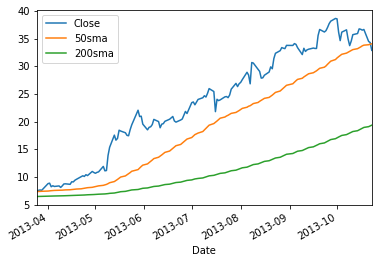

In [10]:
def plot_consecutive_rocketing(hist, record, i):
    hist[record[i]['Open']:record[i]['Close']].plot(y=['Close', '50sma', '200sma'])
    
plot_consecutive_rocketing(hist, record, 15)
    

In [11]:
# or scan over the whole time when over when under -> look for crossovers going up^
# longest range of time when true?

In [12]:
class Crypto:
    def __init__(self):
        cc.cryptocompare._set_api_key_parameter("949879f6b63d8530ac5c1b9576779e8123dfacda449165f7b8be08cb6edbe407")
        
    def get_history(self, symbol='BTC', final_day=datetime.datetime(2019,6,6), days=1000):
        self.history = cc.get_historical_price_day(symbol, currency='USD', limit=days, toTs=final_day)
        self.history = self.to_df(self.history)
        return self.strip_columns_df(self.history)
    
    def strip_columns_df(self, df):
        df = df.drop(columns=['volumefrom', 'volumeto', 'conversionType', 'conversionSymbol'])
        return df
        
    def to_df(self, data_ls):
        dic = {}
        for data in data_ls:
            for key,value in data.items():
                if key not in dic:
                    dic[key] = []

                if key == 'time':
                    value = pd.to_datetime(value, unit='s')
                dic[key].append(value)
        return pd.DataFrame(dic)

In [13]:
# check if above sma50, sma200

In [14]:
class Bot:
    def __init__(self, symbol):
        self.cash = 5000
        self.coins = 0
        self.symbol = symbol
        self.buys = []
        self.sells = []
        
    def buy(self, cost, day):
        self.coins += self.cash/cost
        self.cash = 0
        self.buys.append((cost, self.coins*cost, day))
        
    def sell(self, cost, day):
        self.cash += self.coins*cost
        self.coins = 0
        self.sells.append((cost, self.cash, day))
        
    def report(self):
        for i in range(len(self.buys)):
            print(f"${self.buys[i][1]}: bought {self.symbol} @ ${self.buys[i][0]} each on {self.buys[i][2]}")
            if i < len(self.sells):
                print(f"${self.sells[i][1]}: sold {self.symbol} @ ${self.sells[i][0]} each on {self.sells[i][2]}")
        
    def reset(self, symbol):
        self.cash = 0
        self.coins = 0
        self.symbol = symbol
        self.buys = []
        self.sells = []

In [15]:
def rocketize_coin(df):
    df['sma200'] = df['close'].rolling(200).mean()
    df['sma50'] = df['close'].rolling(50).mean()
    df['rocket'] = [True if df['close'][i] > df['sma50'][i] > df['sma200'][i] else False for i in df.index ]

    bot = Bot('BTC')
    climbing = False
    record = []
    for i in range(len(df)):
        isrocket = df['rocket'][i]
        close = df['close'][i]
        day = df['time'][i]

        if not climbing and isrocket:
            climbing = True
            bot.buy(close, day)
            openclose = {'open':i}
            record.append(openclose)

        elif climbing and not isrocket:
            climbing = False
            bot.sell(close, day)
            openclose = record.pop(0)
            openclose['close'] = i
            record.append(openclose)
    return record, bot, df
    

In [16]:
df = Crypto().get_history("BTC", datetime.datetime.today(), 2000)

In [17]:
record, bot, df = rocketize_coin(df)

In [18]:
record

[{'open': 509, 'close': 1218},
 {'open': 1219},
 {'open': 332, 'close': 1220},
 {'open': 1383},
 {'open': 664, 'close': 1391},
 {'open': 1476},
 {'open': 199, 'close': 1505},
 {'open': 1508},
 {'open': 1083, 'close': 1510},
 {'open': 1524},
 {'open': 440, 'close': 1525},
 {'open': 1537},
 {'open': 1168, 'close': 1581},
 {'open': 1616},
 {'open': 319, 'close': 1808},
 {'open': 1820},
 {'open': 1184, 'close': 1822},
 {'open': 1823},
 {'open': 500, 'close': 1824},
 {'open': 1825},
 {'open': 1200, 'close': 1826},
 {'open': 1827},
 {'open': 256, 'close': 1830},
 {'open': 1958},
 {'open': 1215, 'close': 1963},
 {'open': 1974}]

In [19]:
df

,time,high,low,open,close,sma200,sma50,rocket
0,2016-05-06,461.48,445.72,448.08,459.56,NaN,NaN,False
1,2016-05-07,460.61,454.60,459.56,458.46,NaN,NaN,False
2,2016-05-08,460.18,454.94,458.46,457.87,NaN,NaN,False
3,2016-05-09,464.18,455.38,457.87,460.44,NaN,NaN,False
4,2016-05-10,462.14,446.81,460.44,449.36,NaN,NaN,False
...,...,...,...,...,...,...,...,...
1996,2021-10-23,61733.43,59705.11,60693.59,61313.09,45236.43870,50734.4292,True
1997,2021-10-24,61481.25,59529.34,61313.09,60863.56,45260.99660,50952.9946,True
1998,2021-10-25,63709.97,60658.35,60863.56,63089.04,45286.01950,51179.0922,True
1999,2021-10-26,63290.04,59868.68,63089.04,60315.68,45297.06365,51331.5394,True


In [20]:
bot.report()

$5000.0: bought BTC @ $736.19 each on 2016-11-21 00:00:00
$5334.424537143943: sold BTC @ $785.43 each on 2017-01-11 00:00:00
$5334.424537143943: bought BTC @ $899.66 each on 2017-01-17 00:00:00
$6354.574084323562: sold BTC @ $1071.71 each on 2017-03-17 00:00:00
$6354.574084323562: bought BTC @ $1121.29 each on 2017-03-21 00:00:00
$5920.636621547068: sold BTC @ $1044.72 each on 2017-03-22 00:00:00
$5920.636621547068: bought BTC @ $1147.56 each on 2017-04-03 00:00:00
$12957.287140064096: sold BTC @ $2511.43 each on 2017-07-09 00:00:00
$12957.287140064096: bought BTC @ $2866.02 each on 2017-07-20 00:00:00
$17497.595566436616: sold BTC @ $3870.29 each on 2017-09-13 00:00:00
$17497.595566436616: bought BTC @ $4100.28 each on 2017-09-18 00:00:00
$16676.886351617854: sold BTC @ $3907.96 each on 2017-09-19 00:00:00
$16676.886351617854: bought BTC @ $4212.2 each on 2017-09-27 00:00:00
$52689.094577776814: sold BTC @ $13308.06 each on 2018-01-11 00:00:00
$52689.094577776814: bought BTC @ $10929.

In [21]:
class RocketCrypto:
    def __init__(self, symbol):
        self.df = Crypto().get_history(symbol, datetime.datetime.today(), 300)
        self.df['sma200'] = self.df['close'].rolling(200).mean()
        self.df['sma50'] = self.df['close'].rolling(50).mean()
        self.df['rocket'] = [True if self.df['close'][i] > self.df['sma50'][i] > self.df['sma200'][i] else False for i in self.df.index ]
        self.symbol = symbol
        self.groups = []
        self.bullish = False
        self.check_bullish()
    
    def check_bullish(self):
        # just see whether the market is still bullish, if so since when?
        for i in range(len(self.df)):
            if self.df.iloc[i]['close'] > self.df.iloc[i]['sma50'] > self.df.iloc[i]['sma200']:
                if not self.bullish:
                    self.groups.append([i])
                self.bullish = True
            else:
                if self.bullish:
                    self.groups[-1].append(i)
                self.bullish = False
        if self.bullish == True:
            print(f"{self.symbol} recommended (still bullish)")
            print(f"{self.groups}")
            
    def plot(self, a, b):
        return self.df[a:b].plot(y=['close', 'sma50', 'sma200'])
    

In [22]:
rbtc = RocketCrypto('BTC')

BTC recommended (still bullish)
[[258, 263], [274]]


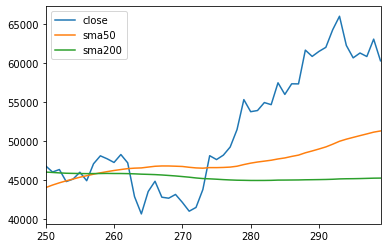

In [23]:
rbtc.plot(250,300)

In [24]:
# so distracted
# just see which of these coins is rocketing up at the moment
coins = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP', 'DOT', 'DOGE', 'LUNA', 'UNI', 'SHIB', 'AVAX', 'LINK', 'ALGO']
analysis = [(coin, RocketCrypto(coin)) for coin in coins]

BTC recommended (still bullish)
[[258, 263], [274]]
ETH recommended (still bullish)
[[205, 214], [220, 263], [274]]
BNB recommended (still bullish)
[[208, 210], [243, 253], [255, 256], [257, 260], [275, 281], [285]]
SOL recommended (still bullish)
[[211]]
XRP recommended (still bullish)
[[244, 262], [282, 291], [292]]
DOT recommended (still bullish)
[[265, 270], [274]]
LUNA recommended (still bullish)
[[230, 264], [265, 290], [292]]
SHIB recommended (still bullish)
[[199, 216], [219, 238], [239, 241], [244, 245], [247, 250], [252, 253], [259, 263], [266, 267], [274]]
AVAX recommended (still bullish)
[[247, 283], [293]]
ALGO recommended (still bullish)
[[256, 291], [293, 294], [295, 297], [298]]


BTC


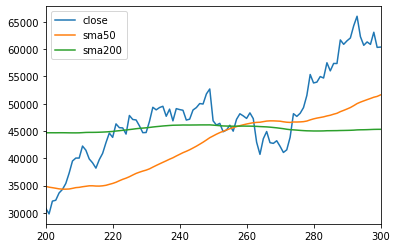

ETH


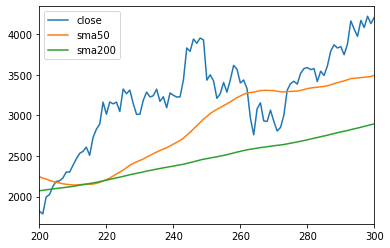

BNB


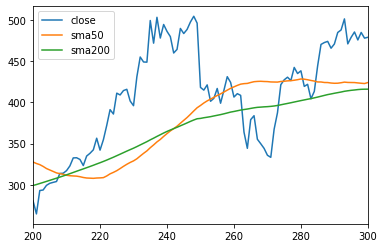

ADA


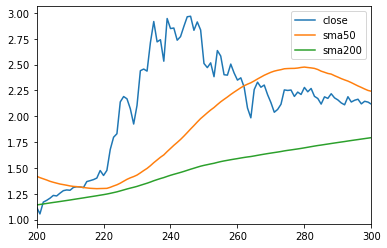

SOL


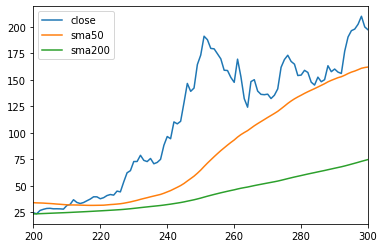

XRP


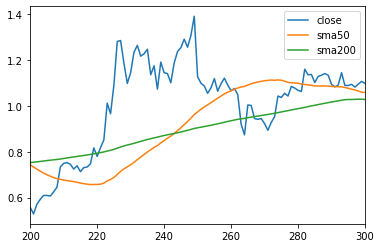

DOT


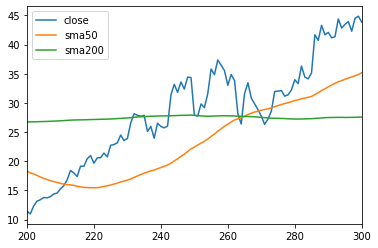

DOGE


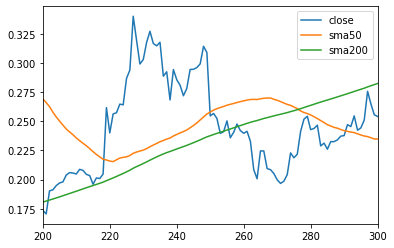

LUNA


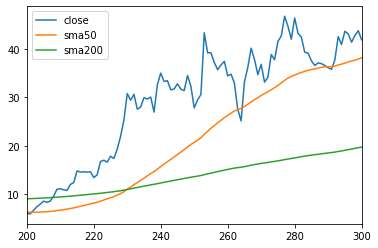

UNI


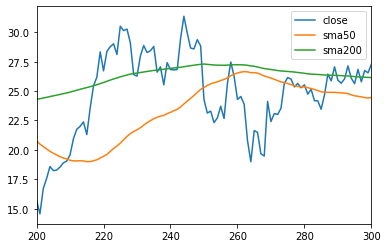

SHIB


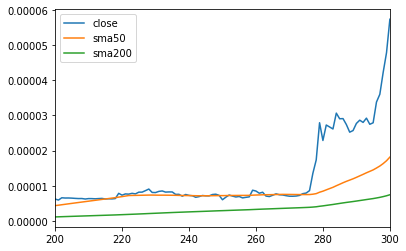

AVAX


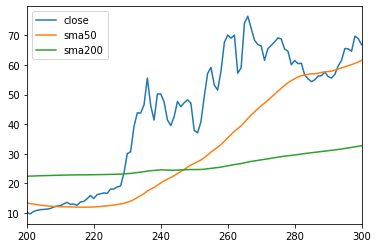

LINK


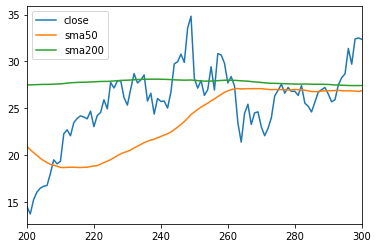

ALGO


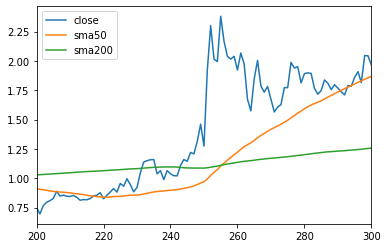

In [25]:
for coin, data in analysis:
    print(coin)
    data.plot(200, 500)
    plt.show()
    

In [26]:
# MACD at its best
# dont trade when big moves at entry (price goes up/down sharply)
# dont trade if 200ema is flat or price keeps going above/below 200ema, good when 200ema upward and price above

In [27]:
# most cryptos died

In [28]:
# make ai figure it out
# just start with lin reg

In [29]:
# [1,2,3,4,5] => y
# what criteria for buying
# some form of the log reg or like a curve fit exponential
# each crypto is basically a logarithmic/ exponential curve with a sin wave volatility 
# do like a line curve fit


In [30]:
# momentum stocks analysis
# top ten % gain for coins daily, weekly, monthly
# buy up those ones
# sell as soon as it loses momentum?

In [31]:
# random forest work backwards?
# first pick the best winners and loser coins
# next try to pick apart any early signs of success
# pick the best times to buy and the best times to sell
# try to pick apart how to determine when those are the case


# like the lowest lows before shooting very high
# what are the signs?
# make it try different criteria until it figures it out?

In [32]:
# patterns repeat themselves?
# support and resistance lines
# deep learning bot?

# learns to trade based on candle patterns
# open, close, high, low, volumeFrom, volumeTo

# can buy, sell, or hold

In [33]:
# open, close, high, low


# 50 avg, 200 avg, RSI, basically every indicator (some way to narrow them down)

# random forest? 50 avg < 200 avg < price?
# keep asking questions to split the dataset
# examples of best times to buy
# examples of best times to sell?


# best time to get into market -> best time to sell for that trade

In [34]:
# given that u have a 1000 indicators, how to narrow down which indicators are giving u good information on whether to buy/sell?

# genetic algorithms -> needs random mutations
# ask random forest what exactly is narrowing it down

In [35]:
# log reg expectations
# some time the drop coming expectations
# 0-1 in terms of hot/cold best times to buy/sell -> how far away from current expected value given history of coin
# current expected value in terms of market cap over time?
# stock to flow?
# with bitcoin market cap over time is exactly proportional to price/time
# map it to a function -> line fit
# https://medium.com/quantodian-publications/bitcoins-natural-long-term-power-law-corridor-of-growth-649d0e9b3c94
# https://medium.com/quantodian-publications/bitcoins-power-oscillator-64875128c56f
# https://www.lookintobitcoin.com/charts/bitcoin-logarithmic-growth-curve/

In [36]:
# so try to guess the future of bitcoin price given the past using curve fit and the following metcalfe network equations:
# utility = n^2
# utility = n * log(n)


In [116]:
def metcalfe_exp(x,a,b):
    return a+b*x**2

def metcalfe_log(x,a,b):
    return a+b*x*np.log10(x)

def linreg(x,a,b):
    return 10**(a+b*np.log10(x))

In [84]:
# takes some x,y ndarrays and a function and plots it with the curve fit

In [111]:
class CurvePlot:
    def __init__(self, x, y, func):
        self.x = x
        self.y = y
        self.func = func
        self.popt = None
        self.fit()
        self.plot()
        
    def fit(self):
        self.popt, _ = curve_fit(self.func, self.x, self.y)
        
    def plot(self):
        plt.plot(self.x, self.y)
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(self.x), max(self.x), 1)
        # calculate the output for the range
        y_line = self.func(x_line, *self.popt)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()

In [112]:
(2021-2012)*365

3285

In [100]:
btc = Crypto().get_history('BTC', datetime.datetime.today(), 2000)

In [89]:
def objective(x, a, b, c):
    return a * x + b * x**2 + c

In [102]:
plt.rcParams["figure.figsize"] = (20,10)

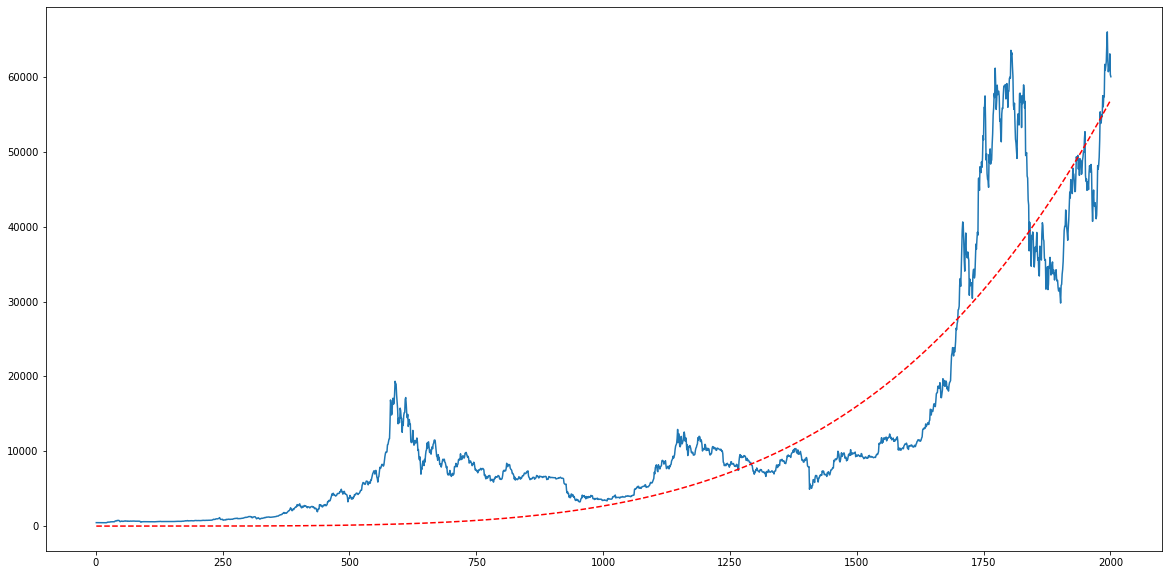

In [113]:
CurvePlot(np.array(range(1,len(btc.values)+1)), btc.values[:,4], linreg)

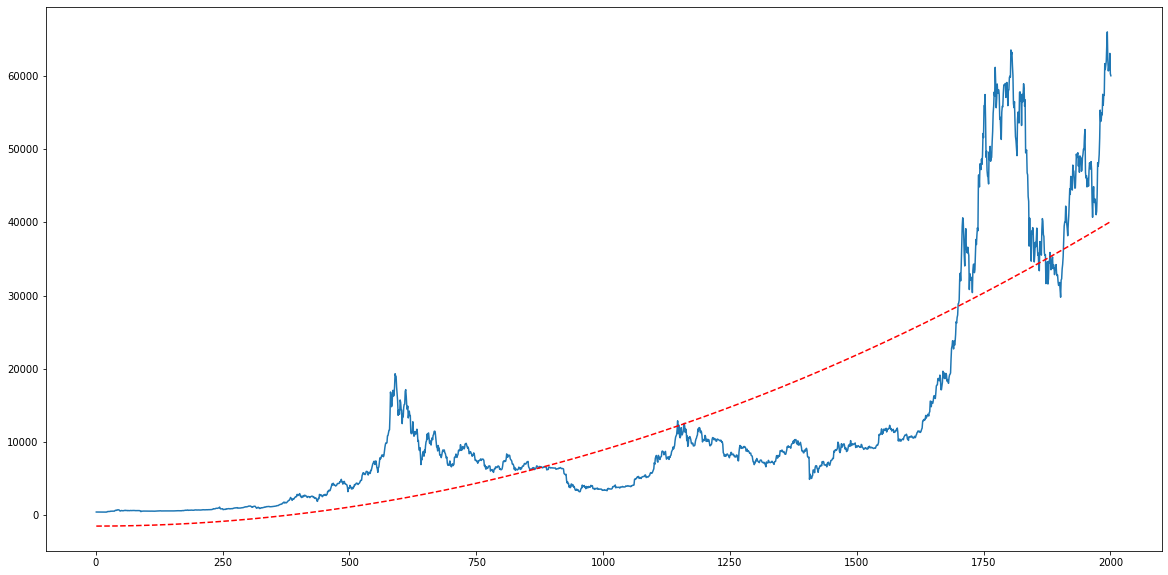

In [114]:
CurvePlot(np.array(range(1,len(btc.values)+1)), btc.values[:,4], metcalfe_exp)

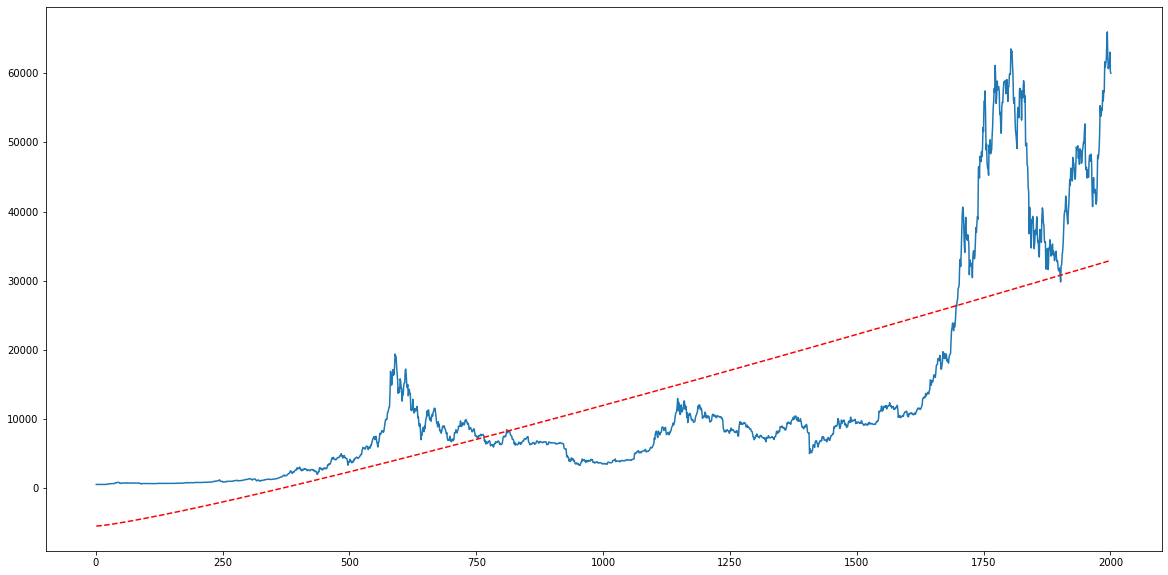

In [117]:
CurvePlot(np.array(range(1,len(btc.values)+1)), btc.values[:,4], metcalfe_log)